In [1]:
from datetime import datetime
import fsspec
from http.cookiejar import CookieJar
from netrc import netrc
import numpy as np
from os.path import basename, isfile, isdir, join, expanduser
from platform import system
from urllib import request
import xarray as xr
import time
import requests
import matplotlib.pyplot as plt
import cartopy
import dask
import requests,s3fs
import numpy.ma as ma
import matplotlib
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
from pathlib import Path 
import glob, os

# Subroutines

In [2]:
def z_masked_overlap(axe, X, Y, Z, source_projection=None):
    """
    for data in projection axe.projection
    find and mask the overlaps (more 1/2 the axe.projection range)

    X, Y either the coordinates in axe.projection or longitudes latitudes
    Z the data
    operation one of 'pcorlor', 'pcolormesh', 'countour', 'countourf'

    if source_projection is a geodetic CRS data is in geodetic coordinates
    and should first be projected in axe.projection

    X, Y are 2D same dimension as Z for contour and contourf
    same dimension as Z or with an extra row and column for pcolor
    and pcolormesh

    return ptx, pty, Z
    """
    if not hasattr(axe, 'projection'):
        return Z
    if not isinstance(axe.projection, cartopy.crs.Projection):
        return Z

    if len(X.shape) != 2 or len(Y.shape) != 2:
        return Z

    if (source_projection is not None and
            isinstance(source_projection, cartopy.crs.Geodetic)):
        transformed_pts = axe.projection.transform_points(
            source_projection, X, Y)
        ptx, pty = transformed_pts[..., 0], transformed_pts[..., 1]
    else:
        ptx, pty = X, Y


    with np.errstate(invalid='ignore'):
        # diagonals have one less row and one less columns
        diagonal0_lengths = np.hypot(
            ptx[1:, 1:] - ptx[:-1, :-1],
            pty[1:, 1:] - pty[:-1, :-1]
        )
        diagonal1_lengths = np.hypot(
            ptx[1:, :-1] - ptx[:-1, 1:],
            pty[1:, :-1] - pty[:-1, 1:]
        )
        to_mask = (
            (diagonal0_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal0_lengths) |
            (diagonal1_lengths > (
                abs(axe.projection.x_limits[1]
                    - axe.projection.x_limits[0])) / 2) |
            np.isnan(diagonal1_lengths)
        )

        # TODO check if we need to do something about surrounding vertices

        # add one extra colum and row for contour and contourf
        if (to_mask.shape[0] == Z.shape[0] - 1 and
                to_mask.shape[1] == Z.shape[1] - 1):
            to_mask_extended = np.zeros(Z.shape, dtype=bool)
            to_mask_extended[:-1, :-1] = to_mask
            to_mask_extended[-1, :] = to_mask_extended[-2, :]
            to_mask_extended[:, -1] = to_mask_extended[:, -2]
            to_mask = to_mask_extended
        if np.any(to_mask):

            Z_mask = getattr(Z, 'mask', None)
            to_mask = to_mask if Z_mask is None else to_mask | Z_mask

            Z = ma.masked_where(to_mask, Z)

        return ptx, pty, Z
        

In [3]:
def pcolormesh_part(LO,LA,data,valmin,valmax,lon0,lonmin,lonmax,latmin,latmax,**karg):
    if 'contour' in karg:
        fig = plt.figure(figsize=(12,8))
        ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))       
        if 'palette2' in karg:
            palette2=karg['palette2']
        else:
            palette2 = plt.cm.Greys
        pp2=ax.pcolormesh(karg['lon_contour'], karg['lat_contour'], karg['contour'], cmap=palette2, transform=cartopy.crs.PlateCarree(), vmin = karg['level_contour'][0], vmax = karg['level_contour'][-1])

    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,5))
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}

    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin+0.5,latmax,2))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    
    if 'palette' in karg:
        palette=karg['palette']
    else:
        palette = plt.cm.jet
    
    pp=ax.pcolormesh(LO.squeeze(), LA.squeeze(), data, cmap=palette, transform=cartopy.crs.PlateCarree(), vmin = valmin, vmax = valmax)

    if 'contour' in karg:  
        matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        X, Y, masked_data = z_masked_overlap(ax, karg['lon_contour'], karg['lat_contour'], karg['contour'], source_projection=cartopy.crs.Geodetic())    
        cc=ax.contour(X,Y,masked_data,levels=karg['level_contour'],cmap=palette2,linewidth=3)

    if 'data3' in karg:  
        pp3=ax.pcolormesh(karg['LO3'].squeeze(), karg['LA3'].squeeze(), karg['data3'], cmap=karg['palette3'], transform=cartopy.crs.PlateCarree(), vmin = karg['valmin3'], vmax = karg['valmax3'])

    cbar_ax = fig.add_axes([0.79, 0.05, 0.02, 0.9])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='vertical',ax=ax)
    h.ax.tick_params(labelsize=16) 
    if 'unit' in karg:
        h.set_label(karg['unit'],fontsize=16)
    if 'contour' in karg:
        if 'optioncolorbar' in karg:
            cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.9])
        else:
            cbar_ax = fig.add_axes([0.88, 0.05, 0.02, 0.9])
        h2=plt.colorbar(pp2, cax=cbar_ax,orientation='vertical',ax=ax)
        h2.ax.tick_params(labelsize=16)
        if 'unit2' in karg:
            h2.set_label(karg['unit2'],fontsize=16)

    if 'title' in karg:
        ax.set_title(karg['title'],fontsize=20)
        gl.top_labels =False
        gl.right_labels =False

    plt.subplots_adjust(right=0.8,left=0.05,top=0.95,bottom=0.05)
    if 'fileout' in karg:
        plt.ioff()
        plt.savefig(karg['fileout'], dpi=fig.dpi)
        plt.close('all')
    else:
        plt.ion()
        plt.show()

In [4]:
def pcolormesh_part2(LO,LA,data,valmin,valmax,lon0,lonmin,lonmax,latmin,latmax,**karg):
    if 'contour' in karg:
        fig = plt.figure(figsize=(12,8))
        ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))       
        if 'palette2' in karg:
            palette2=karg['palette2']
        else:
            palette2 = plt.cm.Greys
        pp2=ax.pcolormesh(karg['lon_contour'], karg['lat_contour'], karg['contour'], cmap=palette2, transform=cartopy.crs.PlateCarree(), vmin = karg['level_contour'][0], vmax = karg['level_contour'][-1])
        plt.close()
        
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=lon0))
    
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=cartopy.crs.PlateCarree()) 
    ax.add_feature(cfeature.LAND, facecolor = '0.75',zorder=1)
    ax.coastlines('10m',zorder=2)
    ax.add_feature(cfeature.RIVERS,facecolor='blue',zorder=3)

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(lonmin,lonmax,5))
    gl.xlabel_style = {'size': 20, 'color': 'k','rotation':0}

    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(latmin+0.5,latmax,2))
    gl.ylabel_style = {'size': 20, 'color': 'gray','rotation':0}
    
    if 'palette' in karg:
        palette=karg['palette']
    else:
        palette = plt.cm.jet
    
    pp=ax.pcolormesh(LO.squeeze(), LA.squeeze(), data, cmap=palette, transform=cartopy.crs.PlateCarree(), vmin = valmin, vmax = valmax)

    if 'contour' in karg:  
        matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
        X, Y, masked_data = z_masked_overlap(ax, karg['lon_contour'], karg['lat_contour'], karg['contour'], source_projection=cartopy.crs.Geodetic())    
        cc=ax.contour(X,Y,masked_data,levels=karg['level_contour'],cmap=palette2,linewidth=3)

    if 'data3' in karg:  
        pp3=ax.pcolormesh(karg['LO3'].squeeze(), karg['LA3'].squeeze(), karg['data3'], cmap=karg['palette3'], transform=cartopy.crs.PlateCarree(), vmin = karg['valmin3'], vmax = karg['valmax3'], alpha = karg['alpha'])
        cbar_ax = fig.add_axes([0.8, 0.05, 0.02, 0.9])
        h3=plt.colorbar(pp3, cax=cbar_ax,orientation='vertical',ax=ax)
        h3.ax.tick_params(labelsize=16)
        h3.set_label(karg['unit3'],fontsize=16)

    cbar_ax = fig.add_axes([0.72, 0.05, 0.02, 0.9])
    h=plt.colorbar(pp, cax=cbar_ax,orientation='vertical',ax=ax)
    h.ax.tick_params(labelsize=16) 
    if 'unit' in karg:
        h.set_label(karg['unit'],fontsize=16)
    if 'contour' in karg:
        cbar_ax = fig.add_axes([0.91, 0.05, 0.02, 0.9])
        h2=plt.colorbar(pp2, cax=cbar_ax,orientation='vertical',ax=ax)
        h2.ax.tick_params(labelsize=16)
        if 'unit2' in karg:
            h2.set_label(karg['unit2'],fontsize=16)

    if 'title' in karg:
        ax.set_title(karg['title'],fontsize=20)
        gl.top_labels =False
        gl.right_labels =False

    plt.subplots_adjust(right=0.75,left=0.04,top=0.95,bottom=0.05)
    if 'fileout' in karg:
        plt.ioff()
        plt.savefig(karg['fileout'], dpi=fig.dpi)
        plt.close('all')
    else:
        plt.ion()
        plt.show()

In [5]:
def init_S3FileSystem():
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem
    """
  
    import requests,s3fs
    credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    return s3, credentials


In [6]:
def update_credential(credentials, force=False):
    now=np.datetime64(datetime.now())
    
    # expiration time of current credential
    exp=np.datetime64(credentials['expiration'][:-6])
    # current time
    
    # how much time is left [seconds]
    td_sec = np.double(exp-now)/1e6

    # if < 1800 seconds left before credential expires, renew it
    if (td_sec < 1800) or (force==True):
        print(f'... updating credentials, {td_sec}s remaining')
        s3, credentials = init_S3FileSystem()
        exp=np.datetime64(credentials['expiration'][:-6])
        td_sec = np.double(exp-now)/1e6
        print(f'... after credential update, {td_sec}s remaining')
    else:
        print(f'... not updating credentials, {td_sec}s remaining')
        
    return credentials

In [7]:
# # do we need that?
# _netrc = join(expanduser('~'), "_netrc" if system()=="Windows" else ".netrc")
# print(_netrc, type(_netrc))

# setup_earthdata_login_auth()

In [8]:
s3, credentials = init_S3FileSystem()

In [9]:
# update_credential(credentials, force=False)

# Load SMAP files

In [10]:
print(datetime(2023,9,14).timetuple().tm_yday)
print(datetime(2023,9,18).timetuple().tm_yday)

257
261


In [11]:
# si en local
# smap_path=Path('/Users/severinf/Data/raw/smap_remss_v6/')
# files = sorted(glob.glob(os.path.join(smap_path,'*.nc')))
# files[0:10]

In [12]:
# year=2023
# smap = xr.open_mfdataset(
#         paths=files,
#         combine='nested',
#         concat_dim='time').sel(time=slice('2023-09-14','2023-09-18'))

In [13]:
ShortName = "SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6"
year=2023
month=9
doystart=datetime(year,month,14).timetuple().tm_yday
doyend=datetime(year,month,18).timetuple().tm_yday
smap_files = s3.glob(join("podaac-ops-cumulus-protected/", ShortName, '*'+str(year)+'_*.nc'))
paths=[s3.open(f) for f in smap_files]

In [14]:
paths[doystart-1:doystart+10]

[<File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_257_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_258_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_259_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_260_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_261_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V6/RSS_smap_SSS_L3_8day_running_2023_262_FNL_v06.0.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/SMAP_RSS

In [15]:
start_time = time.time()
smap = xr.open_mfdataset(paths[doystart-1:doyend],
    combine='nested',
    concat_dim='time',
    decode_cf=True,
    coords='minimal',
    chunks={'time': 1}) 

print(time.time() - start_time)
print((time.time() - start_time)/len(paths))

2.7944881916046143
0.007656514154721613


In [16]:
smap

<xarray.Dataset> Size: 767MB
Dimensions:                 (lon: 1440, lat: 720, time: 5,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * lat                     (lat) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * time                    (time) datetime64[ns] 40B 2023-09-14T12:00:00 ......
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (time, lat, lon) float64 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_RF                 (time, lat, lon) float64 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 41MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap                (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_RF             (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...                      ...
    fland                   (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice_est                (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    surtep                  (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    winspd                  (time, lat, lon) float32 21MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_zones           (time, lat, lon) int8 5MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) int8 16MB dask.array<chunksize=(1, 720, 1440, 2), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V6.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [17]:
[LO_smap,LA_smap]=np.meshgrid(smap.lon,smap.lat)

# Load SIC files

In [18]:
# si en local
# sic_path=Path('/Users/severinf/Data/raw/sic_nsidc/')
# files = sorted(glob.glob(os.path.join(sic_path, '*'+str(year)+'*.nc')))
# files[0:10]

In [19]:
# grid_sic=xr.open_dataset(Path('/Users/severinf/Data/raw/grid_sic_nsidc.nc'))

In [20]:
# sic = xr.open_mfdataset(
#         paths=files,
#         combine='nested',
#         concat_dim='time').sel(time=slice('2023-09-14','2023-09-18'))

In [21]:
sic_path=Path('/home/jpluser/efs-mount-point/sevfour/sic/')
files = sorted(glob.glob(os.path.join(sic_path, '*'+str(year)+'*.nc')))
files[0:10]

['/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230801_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230802_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230803_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230804_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230805_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230806_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230807_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230808_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230809_F17_v05r00.nc',
 '/home/jpluser/efs-mount-point/sevfour/sic/sic_psn25_20230810_F17_v05r00.nc']

In [22]:
grid_sic=xr.open_dataset(Path('/home/jpluser/efs-mount-point/sevfour/grid_sic_nsidc.nc'))

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'melt_onset_day_seaice_conc_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [23]:
sic = xr.open_mfdataset(
        paths=files,
        combine='nested',
        concat_dim='time').sel(time=slice('2023-09-14','2023-09-18'))

In [24]:
sic.cdr_seaice_conc

<xarray.DataArray 'cdr_seaice_conc' (time: 5, y: 448, x: 304)> Size: 3MB
dask.array<getitem, shape=(5, 448, 304), dtype=float32, chunksize=(1, 448, 304), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y        (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time     (time) datetime64[ns] 40B 2023-09-14 2023-09-15 ... 2023-09-18
Attributes:
    standard_name:          sea_ice_area_fraction
    coverage_content_type:  image
    units:                  1
    long_name:              NOAA/NSIDC CDR of Passive Microwave Sea Ice Conce...
    grid_mapping:           crs
    ancillary_variables:    cdr_seaice_conc_stdev cdr_seaice_conc_qa_flag
    valid_range:            [  0 100]

In [25]:
sic=sic.where(sic.cdr_seaice_conc > 0.15)

# Load SWOT file

In [26]:
# swot=xr.open_dataset('/Users/severinf/Data/raw/swot/Beaufort_sea_swot_data.nc')
swot=xr.open_dataset(Path('/home/jpluser/efs-mount-point/sevfour/SWOT/Beaufort_sea_swot_data.nc'))
swot

<xarray.Dataset> Size: 328MB
Dimensions:               (time: 30, num_lines: 989, num_pixels: 69)
Coordinates:
    latitude              (time, num_lines, num_pixels) float64 16MB ...
    longitude             (time, num_lines, num_pixels) float64 16MB ...
  * time                  (time) datetime64[ns] 240B 2023-09-14T08:10:55.4569...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/18)
    SSHA                  (time, num_lines, num_pixels) float64 16MB ...
    SSHA_noiseless        (time, num_lines, num_pixels) float64 16MB ...
    u_g                   (time, num_lines, num_pixels) float64 16MB ...
    v_g                   (time, num_lines, num_pixels) float64 16MB ...
    u_g_noiseless         (time, num_lines, num_pixels) float64 16MB ...
    v_g_noiseless         (time, num_lines, num_pixels) float64 16MB ...
    ...                    ...
    u_east                (time, num_lines, num_pixels) float64 16MB ...
    v_north               (time, num_lines, num_pixels) float64 16MB ...
    u_east_noiseless      (time, num_lines, num_pixels) float64 16MB ...
    v_north_noiseless     (time, num_lines, num_pixels) float64 16MB ...
    ut_g                  (time, num_lines, num_pixels) float64 16MB ...
    ut_g_noiseless        (time, num_lines, num_pixels) float64 16MB ...

In [39]:
lat_swot=np.array(swot.latitude)
lon_swot=np.array(swot.longitude)
ind=np.where(np.logical_and.reduce((lat_swot>=-90,lon_swot>=-180)))
lat_swot=lat_swot[ind]
lat_swot=np.reshape(lat_swot,(int(len(lat_swot)/69),69))
lon_swot=lon_swot[ind]
lon_swot=np.reshape(lon_swot,(int(len(lon_swot)/69),69))
print(lon_swot.shape,lat_swot.shape)

(20461, 69) (20461, 69)


In [28]:
ssh_swot=np.array(swot.SSHA_noiseless)
ssh_swot=ssh_swot[ind]
ssh_swot=np.reshape(ssh_swot,(lat_swot.shape[0],69))
ssh_swot.shape

(20461, 69)

In [29]:
grad_swot=np.array(np.sqrt(swot.grad_ssh_x_noiseless**2+swot.grad_ssh_y_noiseless**2))
grad_swot=grad_swot[ind]
grad_swot=np.reshape(grad_swot,(lat_swot.shape[0],69))
grad_swot.shape

(20461, 69)

In [30]:
track=np.zeros((swot.time.shape[0],swot.num_lines.shape[0],swot.num_pixels.shape[0]))
for i in range(0,len(swot.time)):
    track[i,:,:]=i
track=track[ind]
track=np.reshape(track,(lat_swot.shape[0],69))
track[np.where(~np.isfinite(ssh_swot))]=np.nan
track.shape

(20461, 69)

In [31]:
#weird trace
ssh_swot[np.where(track==25)]=np.nan
ssh_swot[np.where(track==19)]=np.nan

# Figures

In [32]:
lon0=-135
lonmapmin=-145
lonmapmax=-127
latmapmin=68.5
latmapmax=74
land=True

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


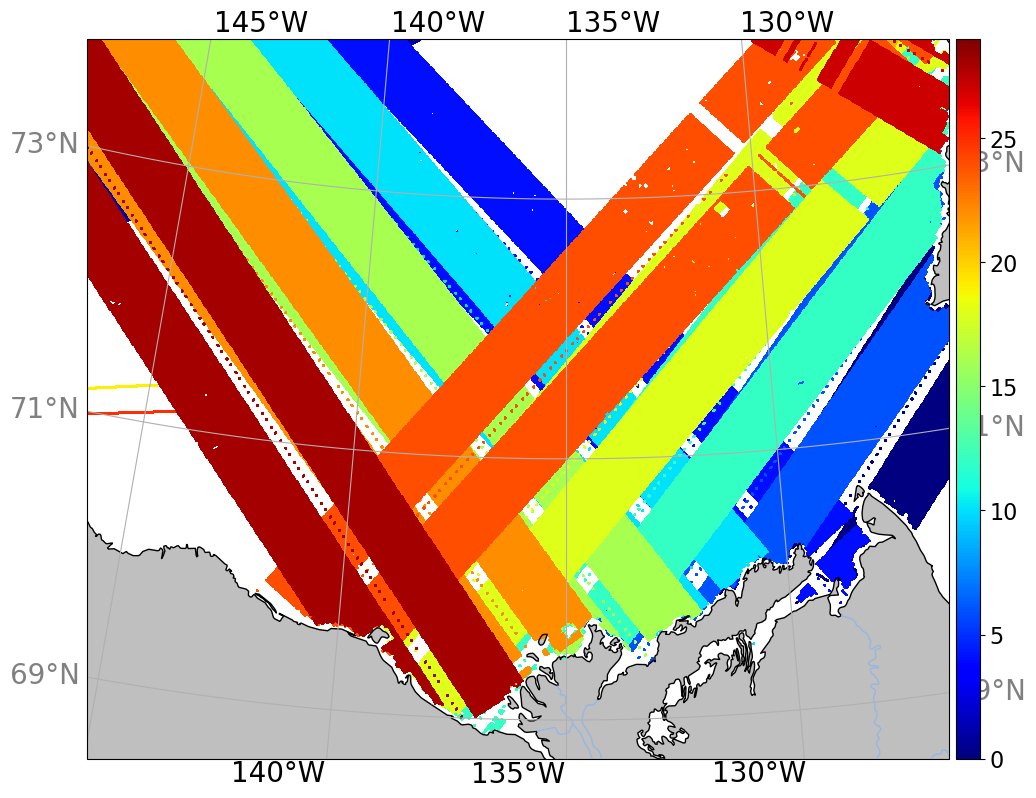

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


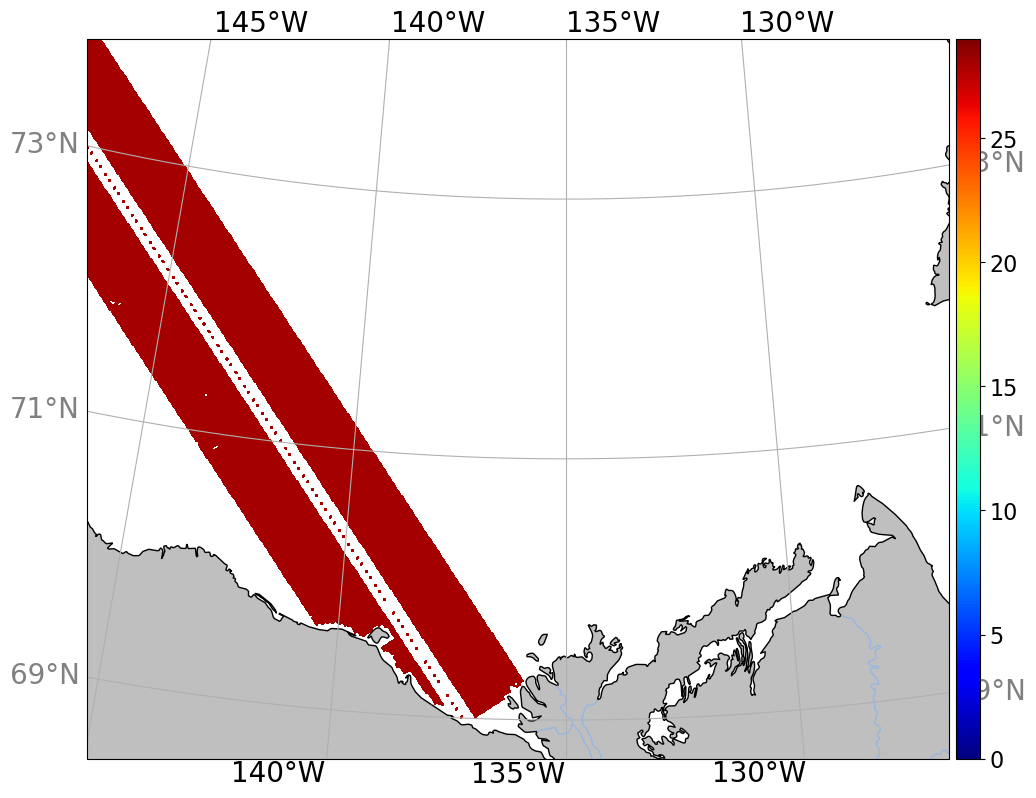

In [55]:
pcolormesh_part(lon_swot,lat_swot,track,0,29,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
       )
tt=np.where(track!=28) #16, 28, 22, 29
track_tmp=+track
track_tmp[tt]=np.nan
pcolormesh_part(lon_swot,lat_swot,track_tmp,0,29,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
       )

In [47]:
lon02=-145
lonmapmin2=-152
lonmapmax2=-142
latmapmin2=69.5
latmapmax2=75

tt=np.where(np.logical_and(track!=22,track!=28))
ssh_swot_tmp=+ssh_swot
ssh_swot_tmp[tt]=np.nan
for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part2(smap.lon,smap.lat,smap.sss_smap[i,:,:],20,30,lon02,lonmapmin2,lonmapmax2,latmapmin2,latmapmax2,palette='jet'
            ,data3=ssh_swot_tmp,LO3=lon_swot,LA3=lat_swot,valmin3=-0.1,valmax3=0.25,palette3='seismic',alpha=0.2
            ,contour=ssh_swot_tmp,lon_contour=lon_swot,lat_contour=lat_swot,level_contour=[round(k,2) for k in np.arange(-0.1,0.26,0.05)],palette2='seismic'
            ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SSS',unit3='SSHA (m)'
            ,fileout=Path('/home/jpluser/Figures/FRESH/smap_swot_transparency_202309'+str(14+i).zfill(2)+'_1.png')
       )

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: fac

In [53]:
swot.time[16]

<xarray.DataArray 'time' ()> Size: 8B
array('2023-09-16T15:54:56.171033258', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2023-09-16T15:54:56.171033258

In [57]:
lon02=-135
lonmapmin2=-140
lonmapmax2=-130
latmapmin2=68.5
latmapmax2=72.5

tt=np.where(np.logical_and(track!=16,track!=28))
ssh_swot_tmp=+ssh_swot
ssh_swot_tmp[tt]=np.nan
for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part2(smap.lon,smap.lat,smap.sss_smap[i,:,:],20,30,lon02,lonmapmin2,lonmapmax2,latmapmin2,latmapmax2,palette='jet'
            ,data3=ssh_swot_tmp,LO3=lon_swot,LA3=lat_swot,valmin3=-0.1,valmax3=0.25,palette3='seismic',alpha=0.2
            ,contour=ssh_swot_tmp,lon_contour=lon_swot,lat_contour=lat_swot,level_contour=[round(k,2) for k in np.arange(-0.1,0.26,0.05)],palette2='seismic'
            ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SSS',unit3='SSHA (m)'
            ,fileout=Path('/home/jpluser/Figures/FRESH/smap_swot_transparency_202309'+str(14+i).zfill(2)+'.png')
       )

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: fac

In [36]:
for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part(smap.lon,smap.lat,smap.sss_smap[i,:,:],20,30,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
                ,data3=sic.cdr_seaice_conc[i,:,:]*100,LO3=grid_sic.longitude,LA3=grid_sic.latitude,valmin3=0,valmax3=100,palette3='Greys'
                ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SSS'
                ,fileout=Path('/home/jpluser/Figures/FRESH/smap_sic_202309'+str(14+i).zfill(2)+'.png')
                # ,fileout='/Users/severinf/Figures/FRESH/smap_sic_202309'+str(14+i).zfill(2)+'.png'
           )

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packag

In [37]:
for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part(smap.lon,smap.lat,smap.sss_smap[i,:,:],20,30,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
            ,contour=ssh_swot,lon_contour=lon_swot,lat_contour=lat_swot,level_contour=[round(k,2) for k in np.arange(-0.1,0.26,0.05)],palette2='Greys'
            ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SSS',unit2='SSHA contours (m)'
            ,fileout=Path('/home/jpluser/Figures/FRESH/smap_swot_202309'+str(14+i).zfill(2)+'.png')
            # ,fileout='/Users/severinf/Figures/FRESH/smap_swot_202309'+str(14+i).zfill(2)+'.png'
           )
    
pcolormesh_part(lon_swot,lat_swot,ssh_swot,-0.1,0.25,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='seismic'
            ,contour=ssh_swot,lon_contour=lon_swot,lat_contour=lat_swot,level_contour=[round(k,2) for k in np.arange(-0.1,0.26,0.05)],palette2='Greys'
            ,title='14-18 Sept 2023',unit2='SSHA (m)'
            ,fileout=Path('/home/jpluser/Figures/FRESH/swotssh_swot_2023091418.png')
            # ,fileout='/Users/severinf/Figures/FRESH/swotssh_swot_2023091418.png'
        )

for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part(lon_swot,lat_swot,ssh_swot,-0.1,0.25,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='seismic',optioncolorbar=True
            ,contour=smap.sss_smap[i,:,:].squeeze(),lon_contour=LO_smap,lat_contour=LA_smap,level_contour=[round(k,2) for k in np.arange(20,30.1,0.5)],palette2='jet'
            ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SHA (m)',unit2='SSS contours'
            ,fileout=Path('/home/jpluser/Figures/FRESH/swotssh_smap_202309'+str(14+i).zfill(2)+'.png')
            # ,fileout='/Users/severinf/Figures/FRESH/swotssh_smap_202309'+str(14+i).zfill(2)+'.png'
           )

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: fac

In [38]:
for i in range(0,smap.sss_smap.shape[0]):
    pcolormesh_part(smap.lon,smap.lat,smap.sss_smap[i,:,:],20,30,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
                ,title=str(pd.to_datetime(smap.time[i].values).date()),unit='SSS'
                ,fileout=Path('/home/jpluser/Figures/FRESH/smap_202309'+str(14+i).zfill(2)+'.png')
                # ,fileout='/Users/severinf/Figures/FRESH/smap_202309'+str(14+i).zfill(2)+'.png'
           )
pcolormesh_part(lon_swot,lat_swot,ssh_swot,-0.1,0.25,lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='seismic'
            ,title='14-18 Sept 2023',unit='SSHA (m)'
            ,fileout=Path('/home/jpluser/Figures/FRESH/swotssh_2023091418.png')
            # ,fileout='/Users/severinf/Figures/FRESH/swotssh_2023091418.png'
       )
pcolormesh_part(lon_swot,lat_swot,grad_swot,-0,1*10**(-5),lon0,lonmapmin,lonmapmax,latmapmin,latmapmax,palette='jet'
            ,title='14-18 Sept 2023',unit='SSHA gradient magnitude'
            ,fileout=Path('/home/jpluser/Figures/FRESH/swotgrad_2023091418.png')
            # ,fileout='/Users/severinf/Figures/FRESH/swotgrad_2023091418.png'
       )

/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jpluser/miniforge3/envs/jupyter/lib/python3.11/site-packag

KeyboardInterrupt: 